In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

from catboost import Pool, CatBoostRegressor

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler

# Импортируем pytorch
import torch
import torch.nn as nn

pd.set_option('display.max_rows', 500)

In [167]:
df = pd.read_csv("ffkkmo_clean.csv", index_col='Unnamed: 0')
df_judges = pd.read_csv("ffkkmo_judges_clean.csv", index_col='Unnamed: 0')

In [168]:
cat_ord = [
    'Юный фигурист, мальчики',
    'Юный фигурист, девочки',
    '3-й юношеский разряд, мальчики',
    '3-й юношеский разряд, девочки',
    '2-й юношеский разряд, мальчики',
    '2-й юношеский разряд, девочки',
    '1-й юношеский разряд, мальчики',
    '1-й юношеский разряд, девочки',
    '3-й спортивный разряд, мальчики',
    '3-й спортивный разряд, девочки', 
    '2-й спортивный разряд, мальчики',
    '2-й спортивный разряд, девочки',
    '1-й спортивный разряд, мальчики',
    '1-й спортивный разряд, девочки',
    'КМС, юноши',
    'КМС, девушки',
    'МС, юноши',
    'МС, девушки'
]

In [169]:
df = df.drop(df.query("category not in @cat_ord").index).reset_index()

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30517 entries, 0 to 30516
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       30517 non-null  int64  
 1   date        30517 non-null  object 
 2   place       30517 non-null  object 
 3   online      30517 non-null  object 
 4   category    30517 non-null  object 
 5   segment     30517 non-null  object 
 6   rank        30517 non-null  int64  
 7   firstname   30517 non-null  object 
 8   middlename  1296 non-null   object 
 9   lastname    30517 non-null  object 
 10  club        30517 non-null  object 
 11  tss         30517 non-null  float64
 12  tes         30517 non-null  float64
 13  pcs         30517 non-null  float64
 14  year        30517 non-null  int64  
 15  month       30517 non-null  int64  
 16  season      30517 non-null  int64  
dtypes: float64(3), int64(5), object(9)
memory usage: 4.0+ MB


In [171]:
df['name'] = df.firstname + df.lastname

In [172]:
df_spec = df_judges[df_judges['function'] == 'Технический специалист'].groupby(['date', 'online']).first()
df_spec = df_spec.rename(columns={"name": "ts"})
df_cont = df_judges[df_judges['function'] == 'Технический контролер'].groupby(['date', 'online']).first()
df_cont = df_cont.rename(columns={"name": "tc"})

In [173]:
df = df.merge(df_spec.merge(df_cont, on=['date', 'online'])[['ts', 'tc']].reset_index(), on=['date', 'online'])

In [174]:
shifted_df = df.groupby(['category', 'segment', 'name']).shift(+1)
df['tss_lag'] = shifted_df['tss']
df['tes_lag'] = shifted_df['tes']
df['pcs_lag'] = shifted_df['pcs']

In [224]:
num_columns = ['tss_lag', 'tes_lag', 'pcs_lag']
ohe_columns = ['segment', 'name', 'ts', 'tc', 'place', 'club']
ord_columns = ['category', 'season', 'month']
target = ['tss']

event_date = '2025-05-24'

train = df.drop(df[df['date'] == event_date].index).reset_index(drop=True)
test = df.drop(df[df['date'] != event_date].index).reset_index(drop=True)

X_train = train[num_columns + ohe_columns + ord_columns]
X_test = test[num_columns + ohe_columns + ord_columns]
y_train = train[target]
y_test = test[target]

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    cat_ord,
                    [2021, 2122, 2223, 2324, 2425],
                    [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('num', 'passthrough', num_columns),
        ('ohe', 'passthrough', ohe_columns),
        ('ord', ord_pipe, ord_columns),
    ], 
    remainder='passthrough'
)
X_train_preprocessed = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=num_columns + ohe_columns + ord_columns)
X_test_preprocessed = pd.DataFrame(data_preprocessor.transform(X_test), columns=num_columns + ohe_columns + ord_columns)

X_train_preprocessed.shape, X_test_preprocessed.shape

((29805, 12), (178, 12))

### DummyRegressor

In [225]:
# Протестируем самую простую модель "Заглушка"
model_dr = DummyRegressor(strategy="mean")
model_dr.fit(X_train_preprocessed, y_train)
model_dr_pred = model_dr.predict(X_test_preprocessed)
dr_mae = mean_absolute_error(model_dr_pred, y_test)
print(f'Значение метрики самой простой модели "Заглушки" MAE = {dr_mae:0.2f}')

Значение метрики самой простой модели "Заглушки" MAE = 12.79


### CatBoostRegressor

In [226]:
cat = CatBoostRegressor(
    loss_function='MAE',
    cat_features=ohe_columns,
    verbose=100
)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(
    grid, 
    X=X_train_preprocessed, 
    y=y_train,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 31.9161772	test: 31.8803737	best: 31.8803737 (0)	total: 37.3ms	remaining: 37.3s
100:	learn: 4.9024529	test: 4.8155216	best: 4.8155216 (100)	total: 1.49s	remaining: 13.3s
200:	learn: 3.3388236	test: 3.2592530	best: 3.2592530 (200)	total: 2.5s	remaining: 9.96s
300:	learn: 3.1467062	test: 3.0820204	best: 3.0820204 (300)	total: 3.48s	remaining: 8.08s
400:	learn: 3.0684316	test: 3.0140082	best: 3.0140082 (400)	total: 4.44s	remaining: 6.63s
500:	learn: 3.0173874	test: 2.9720339	best: 2.9720339 (500)	total: 5.46s	remaining: 5.44s
600:	learn: 2.9878480	test: 2.9506939	best: 2.9506939 (600)	total: 6.48s	remaining: 4.3s
700:	learn: 2.9621163	test: 2.9324791	best: 2.9324791 (700)	total: 7.49s	remaining: 3.19s
800:	learn: 2.9434249	test: 2.9184344	best: 2.9184344 (800)	total: 8.5s	remaining: 2.11s
900:	learn: 2.9267011	test: 2.9073457	best: 2.9073457 (900)	total: 9.5s	remaining: 1.04s
999:	learn: 2.9120242	test: 2.8972138	best: 2.8972138 (999)	total: 10.6s	remaining: 0us

bestTest = 2.89

In [227]:
model = cat

In [228]:
y_pred = model.predict(X_test_preprocessed)

In [229]:
result = pd.concat([test, pd.DataFrame(y_pred)], axis=1)

In [230]:
result = result.groupby(['category', 'segment', 'name']).first().sort_values(by='tss', ascending=False)
result

index  \
category                        segment                name                           
1-й спортивный разряд, девочки  Произвольная программа СофьяАРХИНА            30803   
                                                       ВасилисаМАМЛЕВА        30804   
                                                       МарусяКАНАЕВА          30805   
                                                       АринаВЕСНИНА           30806   
                                                       МарияКЛИМЕНКО          30807   
                                                       АлександраКРУТОВА      30808   
                                                       АринаКОТОСОНОВА        30809   
                                                       ВасилисаЕГОРОВА        30810   
                                                       ЕлизаветаБРОШКО        30811   
                                                       ЕкатеринаРУЗМАНОВА     30812   
                                                       АлисаКОВАЛЬСКАЯ        30813   
                                                       АннаАНТОНОВА           30814   
                                                       АнастасияЗАЙЦЕВА       30815   
2-й спортивный разряд, девочки  Произвольная программа МиленаСЛЕПЦОВА         30750   
1-й спортивный разряд, мальчики Произвольная программа АлександрШУВАЛОВ       30821   
2-й спортивный разряд, девочки  Произвольная программа ТаисияБЕРНАДСКАЯ       30751   
1-й спортивный разряд, девочки  Произвольная программа ОльгаВДОВИЧЕНКО        30816   
                                                       АнастасияКОЛОБАНОВА    30817   
КМС, девушки                    Произвольная программа ЕкатеринаАБРАМОВА      30823   
1-й спортивный разряд, девочки  Произвольная программа ЕлизаветаМУРАВЬЕВА     30818   
2-й спортивный разряд, девочки  Произвольная программа ЭлизаЗАКАРЯН           30752   
                                                       АлександраЕЛИСОВА      30753   
1-й спортивный разряд, девочки  Произвольная программа ВарвараТЯПКОВА         30819   
2-й спортивный разряд, девочки  Произвольная программа АленаКРУПИНА           30754   
                                                       ВалерияЛАЗАРЕВА        30755   
                                                       МиланаШУЛЯК            30756   
                                                       ВикторияКОРОБЕЙНИКОВА  30757   
1-й спортивный разряд, девочки  Короткая программа     АлександраКРУТОВА      30786   
2-й спортивный разряд, девочки  Произвольная программа ЕсенияНАБЕРЕЖНЕВА      30758   
                                                       КристинаОРЕШКИНА       30759   
                                                       ВарвараКУЗОВКОВА       30760   
                                                       ЕлизаветаСТАДНИК       30761   
                                                       ЕлизаветаЖОЛОБОВА      30762   
                                                       СофияАНТОШКИНА         30763   
                                                       СофьяСЕМЕНИХИНА        30764   
                                                       СерафимаКРУКОВИЧ       30765   
                                                       ДианаСУХОВА            30766   
                                                       ВарвараФЕДОРОВА        30767   
                                                       МаргаритаЭЛЬТАРОВА     30768   
1-й спортивный разряд, девочки  Короткая программа     АринаВЕСНИНА           30787   
2-й спортивный разряд, девочки  Произвольная программа ВикторияЛЕОНИДОВА      30769   
1-й спортивный разряд, девочки  Короткая программа     АринаКОТОСОНОВА        30788   
2-й спортивный разряд, девочки  Произвольная программа ПолинаЛЕВАДО           30770   
                                                       УльянаСКВОЛЫГИНА       30771   
                                                       ЕвгенияЖЕЛЕЗНОВА     

In [231]:
# df.reset_index(inplace=True, drop=True)
result.to_csv("prediction.csv")

In [232]:
rr = result.reset_index()
rr['diff'] =  rr['tss'] - rr[0]
rr[['name', 'tss_lag', 0, 'tss', 'diff']]

,name,tss_lag,0,tss,diff
0,СофьяАРХИНА,70.66,69.050888,83.84,14.789112
1,ВасилисаМАМЛЕВА,70.93,71.515223,82.37,10.854777
2,МарусяКАНАЕВА,77.58,72.592834,82.21,9.617166
3,АринаВЕСНИНА,76.21,81.998976,78.27,-3.728976
4,МарияКЛИМЕНКО,NaN,62.924759,75.73,12.805241
5,АлександраКРУТОВА,66.40,66.791591,75.17,8.378409
6,АринаКОТОСОНОВА,70.68,73.431021,73.22,-0.211021
7,ВасилисаЕГОРОВА,58.84,61.427260,69.28,7.852740
8,ЕлизаветаБРОШКО,70.53,68.253355,69.19,0.936645
9,ЕкатеринаРУЗМАНОВА,63.34,65.146842,69.03,3.883158


In [233]:
rr['diff'].describe()

count    178.000000
mean       1.317261
std        3.790279
min      -12.476632
25%       -0.754728
50%        1.098560
75%        3.148276
max       14.789112
Name: diff, dtype: float64

<Axes: xlabel='category,segment,name'>

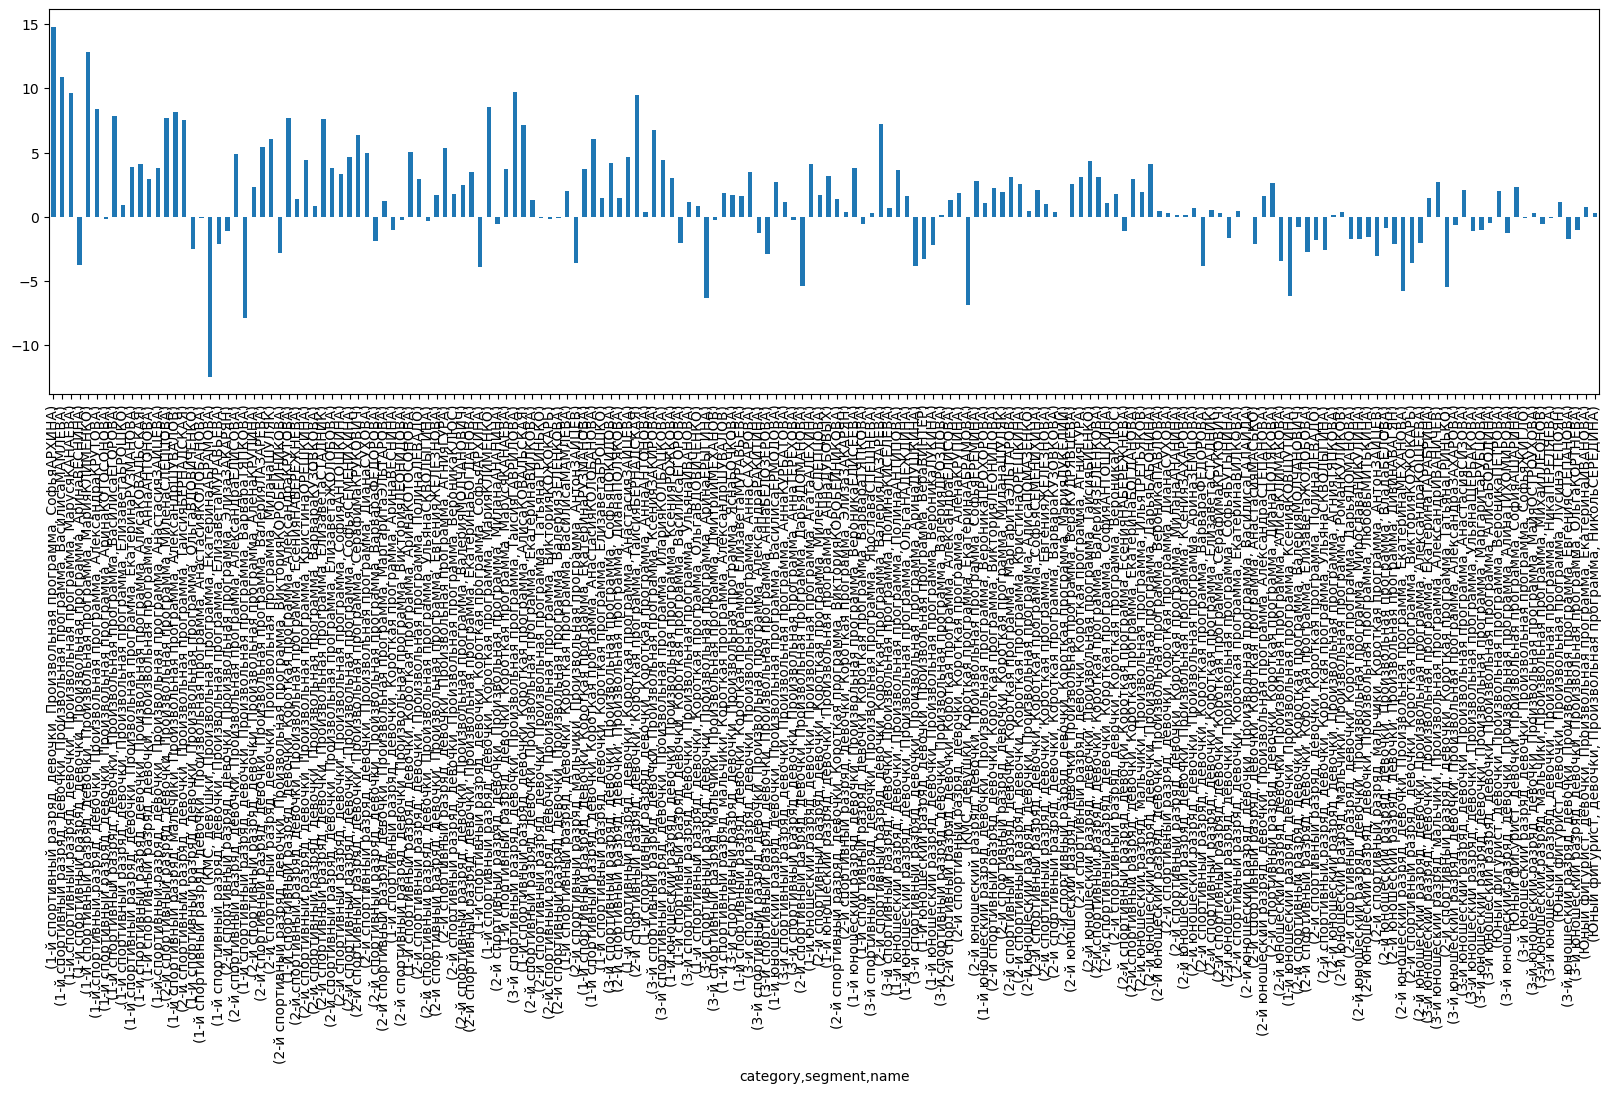

In [234]:
(result['tss'] - result[0]).plot(kind='bar', figsize=(20, 5))

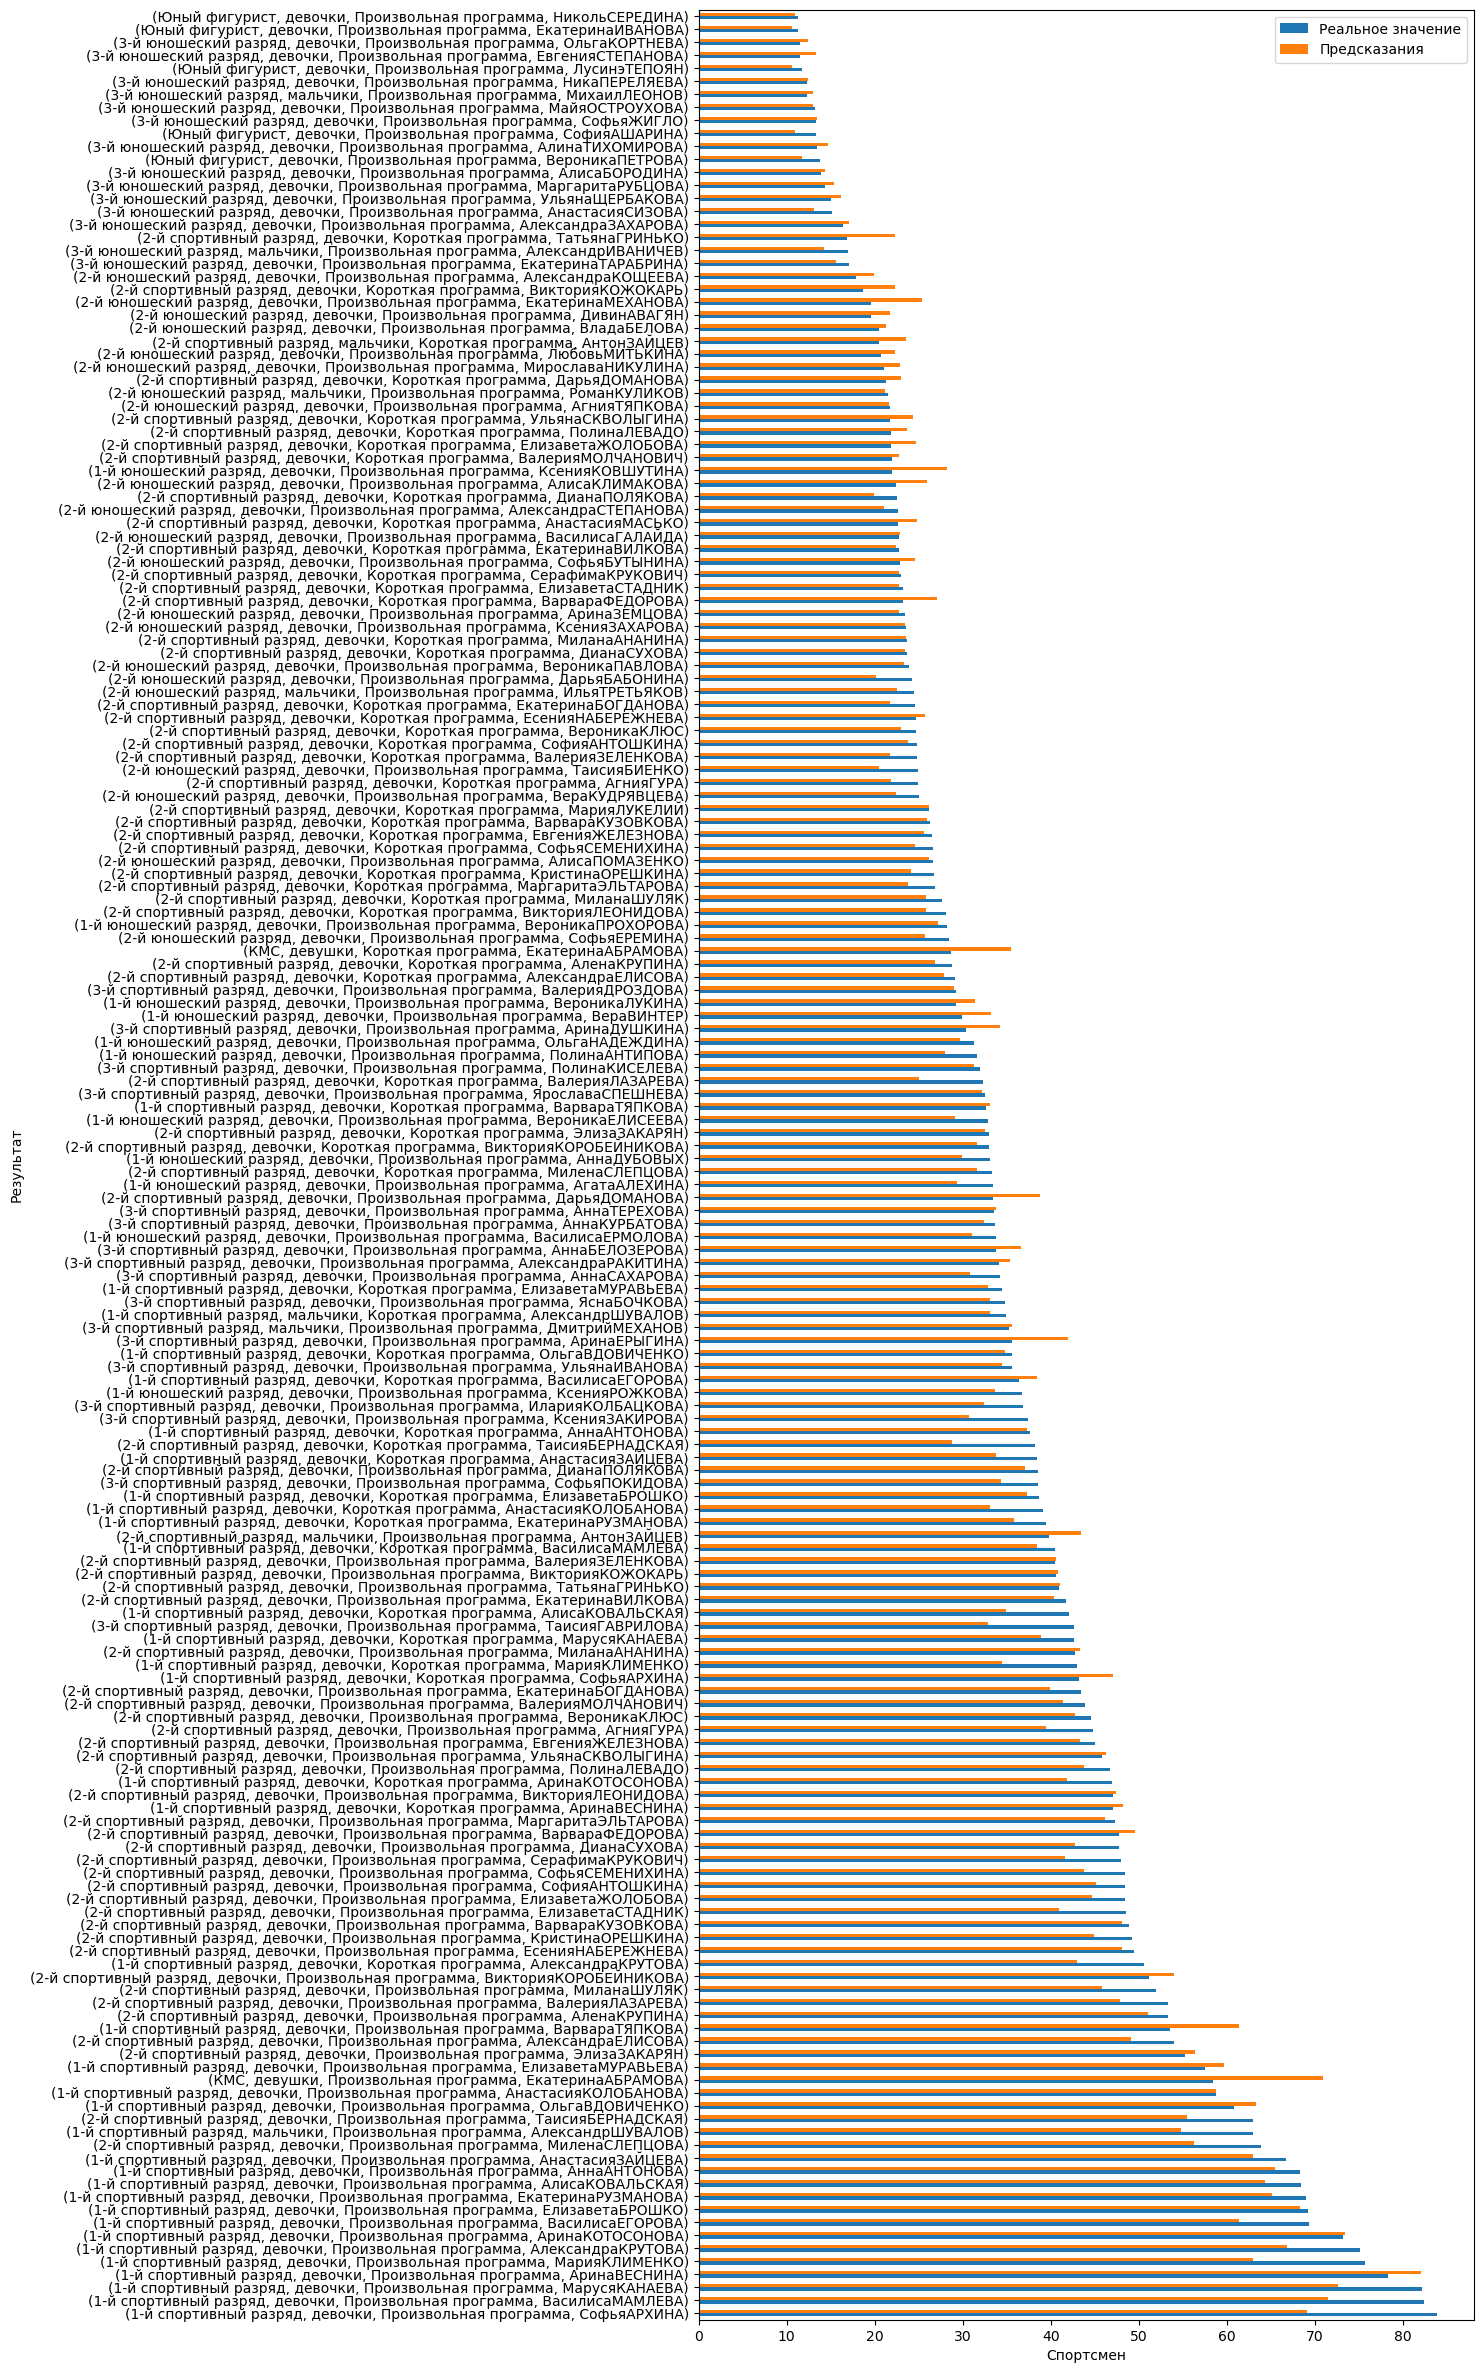

In [235]:
fig = result[['tss', 0]].plot(kind='barh', figsize=(10, 30))
fig.legend(['Реальное значение', 'Предсказания'])
fig.set_ylabel('Результат')
fig.set_xlabel('Спортсмен');

<Axes: >

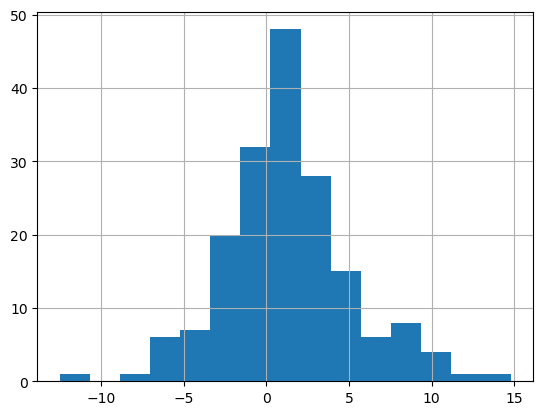

In [237]:
rr['diff'].hist(bins=15)